<a href="https://colab.research.google.com/github/visheshagrawal/Knee_Osteoarthiritis_Classification/blob/main/Knee_Osteoarthritis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Osteoarthritis Project
---

OA is classified into the following five Grades:
1. Grade 0: Normal
2. Grade 1: Doubtful
3. Grade 2: Mild
4. Grade 3: Moderate
5. Grade 4: Severe

We combined the data and worked with the following three classes:
1. Normal: Grade 0 (Normal)
2. Early: Grade 2 (Mild), Grade 3 (Moderate)
3. Late: Grade 4 (Severe)

# Data Visualization
---

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
transform = transforms.Compose([transforms.Resize((300,300)),
                                transforms.ToTensor() ])

augmentation_transform = transforms.Compose([transforms.Resize((300,300)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.RandomRotation(degrees=(-90, 90)),
                                            transforms.RandomAutocontrast(),
                                            transforms.ColorJitter(hue=.05, saturation=.05),
                                            transforms.ToTensor()])

### A. Before Cleaning
---

In [ ]:
train_dir_new = "/content/drive/MyDrive/Osteoarthritis Project Material/Data Received (Knee X-ray)/X-Ray Images/9-7-21/X ray all grades Full data"
train_dataset_new = datasets.ImageFolder(train_dir_new)

In [ ]:
train_dir_old = "/content/drive/MyDrive/Osteoarthritis Project Material/Data Received (Knee X-ray)/X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-I"
train_dataset_old = datasets.ImageFolder(train_dir_old)

In [ ]:
concat_dataset = torch.utils.data.ConcatDataset([train_dataset_new, train_dataset_old])
print('Total sample size:', len(concat_dataset))

In [ ]:
from collections import Counter

data_old = dict(Counter(train_dataset_new.targets))
data_new = dict(Counter(train_dataset_old.targets))

print(data_old)
print(data_new)

In [ ]:
data = Counter(data_old) + Counter(data_new)
data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

names = list(data.keys())
values = list(data.values())

sns.set_theme()
sns.color_palette("pastel")

plt.figure(figsize=(7,6))
plt.bar(range(len(data)), values, tick_label=names)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Count of Each Grade')

print('Total Sample Size (Before Cleaning):', sum(values), '\n')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = Counter(data_old) + Counter(data_new)

data['Grade 0'] = data.pop(0)
data['Grade 1'] = data.pop(1)
data['Grade 2'] = data.pop(2)
data['Grade 3'] = data.pop(3)
data['Grade 4'] = data.pop(4)

names = list(data.keys())
values = list(data.values())

sns.set_theme()
sns.color_palette("pastel")

plt.figure(figsize=(6,6))
plt.pie(values, labels=names, autopct='%1.2f%%')
plt.title('Grade Distribution')
plt.legend(bbox_to_anchor=(0.9, 1))
plt.show()

### B. After Cleaning
---

In [ ]:
transform = transforms.Compose([transforms.Resize((300,300)),
                                transforms.ToTensor()])

In [ ]:
train_dir = "/content/drive/MyDrive/Knee_Osteo_Project/Dataset3Way_remove_grade1"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

In [ ]:
from collections import Counter
from tabulate import tabulate

data_dict = dict(Counter(train_dataset.targets))

print(data_dict)
print()
print(tabulate([[data_dict[2], data_dict[1], data_dict[0]]], headers=['Normal', 'Late', 'Early'],
               tablefmt='presto'))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_dict = dict(Counter(train_dataset.targets))
data_dict['Early'] = data_dict.pop(0)
data_dict['Late'] = data_dict.pop(1)
data_dict['Normal'] = data_dict.pop(2)

data = Counter(data_dict)

names = list(data.keys())
values = list(data.values())

sns.set_theme()
sns.color_palette("pastel")

plt.figure(figsize=(6,6))
plt.bar(range(len(data)), values, tick_label=names)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Each Class (Normal, Late & Early)')

print('\nTotal sample size (After Cleaning):', sum(values))

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_dict = dict(Counter(train_dataset.targets))
data_dict['Early'] = data_dict.pop(0)
data_dict['Late'] = data_dict.pop(1)
data_dict['Normal'] = data_dict.pop(2)

data = Counter(data_dict)

names = list(data.keys())
values = list(data.values())

names = list(data.keys())
values = list(data.values())

sns.set_theme()
sns.color_palette("pastel")

plt.figure(figsize=(7,7))
plt.pie(values, labels=names, autopct='%1.2f%%')
plt.title('Grade Distribution')
plt.legend(bbox_to_anchor=(0.9, 1))
plt.show()

#Data Preprocessing
---

### A. Check for Images with Both Legs

In [ ]:
single_cnt = 0
double_cnt = 0
error_cnt = 0

size_arr = []

for i in range(len(train_dataset_old)):
  res = np.asarray(train_dataset_old[i][0]).shape
  size_arr.append(res[1])
  if res[1] == 300:
    single_cnt += 1
  elif res[1] == 640:
    double_cnt += 1
  else:
    error_cnt += 1
print(single_cnt, double_cnt, error_cnt)

1464 186 0


{640, 300}


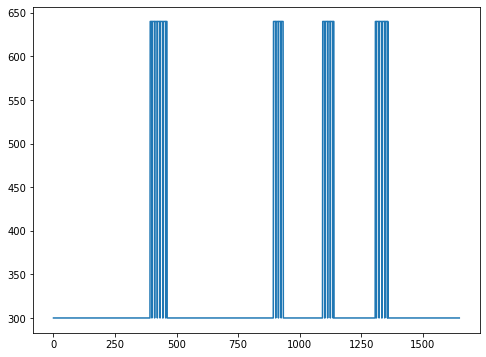

In [ ]:
import matplotlib.pyplot as plt
len(size_arr)
print(set(size_arr))
plt.figure(figsize=(8,6))
plt.plot(size_arr)

In [ ]:
single_cnt2 = 0
double_cnt2 = 0
error_cnt2 = 0

size_arr2 = []

for i in range(len(train_dataset_new)):
  res = np.asarray(train_dataset_new[i][0]).shape
  size_arr2.append(res[1])
  if res[1] == 300:
    single_cnt2 += 1
  elif res[1] == 640:
    double_cnt2 += 1
  else:
    error_cnt2 += 1
print(single_cnt2, double_cnt2, error_cnt2)

0 0 9805


{224}


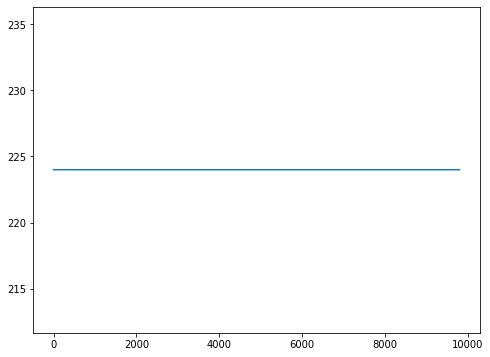

In [ ]:
import matplotlib.pyplot as plt
len(size_arr2)
print(set(size_arr2))
plt.figure(figsize=(8,6))
plt.plot(size_arr2)

This shows that all the data in this folder has only one size - `240 px`.

In [ ]:
single_imgs = single_cnt + single_cnt2
double_imgs = double_cnt + double_cnt2
error_imgs = error_cnt + error_cnt2
print(single_imgs, double_imgs, error_imgs)

1464 186 9805


This shows that the data in this folder has one of the following two sizes - `300 px` and `640 px`.

Our data has:

`11269` images that have scans of only one leg.


`186` images that have scans of both legs.

### B. Check for Duplicates
---

In [ ]:
import cv2
import tqdm

def is_same(img1, img2):
  if img1.shape == img2.shape:
    difference = cv2.subtract(img1, img2)
    b, g, r = cv2.split(difference)
    if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
      return True
  return False

dir1 = '/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-I/0Normal'
dir2 = '/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-II/0Normal'

# img1 = cv2.imread('/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-I/0Normal/NormalG0 (1).png')
# img2 = cv2.imread('/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-II/0Normal/NormalG0 (1).png')
# print(is_same(img1,img2))

all_paths_dir1 = []
for root, dirs, files in os.walk(dir1):
  for f in files:
    img_path = dir1 + '/' + str(f)
    all_paths_dir1.append(img_path)

all_paths_dir2 = []
for root, dirs, files in os.walk(dir2):
  for f in files:
    img_path = dir2 + '/' + str(f)
    all_paths_dir2.append(img_path)

print(len(all_paths_dir1), len(all_paths_dir2))

dup_0Normal = []

for i in all_paths_dir1:
  for j in all_paths_dir2:
    img1 = cv2.imread(i)
    img2 = cv2.imread(j)
    res = is_same(img1,img2)
    if res == True:
      dup_0Normal.append([i,j])
      print([i,j])

print(dup_0Normal)

514 503
['/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-I/0Normal/NormalG0 (8).png', '/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-II/0Normal/NormalG0 (8).png']
['/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-I/0Normal/NormalG0 (5).png', '/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-II/0Normal/NormalG0 (5).png']
['/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-I/0Normal/NormalG0 (6).png', '/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-II/0Normal/NormalG0 (6).png']
['/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-I/0Normal/NormalG0 (4).png', '/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-II/0Normal/NormalG0 (4).png']
['/content/drive

In [ ]:
import cv2
import tqdm

def is_same(img1, img2):
  if img1.shape == img2.shape:
    difference = cv2.subtract(img1, img2)
    b, g, r = cv2.split(difference)
    if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
      return True
  return False

dir1 = '/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-I/0Normal'
dir2 = '/content/drive/MyDrive/DATA Recieved /X-Ray Images/8-7-21 /Knee X-ray Images/MedicalExpert-II/0Normal'

all_paths_dir1 = []
for root, dirs, files in os.walk(dir1):
  for f in files:
    img_path = dir1 + '/' + str(f)
    all_paths_dir1.append(img_path)

dup = []
s = []
for i in range(450, len(all_paths_dir1)):
  img = cv2.imread(all_paths_dir1[i])
  img = tuple(map(tuple, img))
  s.append(img)

print(s)

## B.  Create New Folder
---

In [ ]:
import os
import cv2
from tqdm import tqdm

input_folder = ['/content/drive/MyDrive/Data Received (Knee X-ray)/X-Ray Images/9-7-21/X ray all grades Full data/Grade 1',
                '/content/drive/MyDrive/Data Received (Knee X-ray)/X-Ray Images/9-7-21/X ray all grades Full data/Grade 2',
                '/content/drive/MyDrive/Data Received (Knee X-ray)/X-Ray Images/9-7-21/X ray all grades Full data/Grade 3',
                '/content/drive/MyDrive/Data Received (Knee X-ray)/X-Ray Images/9-7-21/X ray all grades Full data/Grade 4']

output_folder = ['/content/drive/MyDrive/Knee_Osteo_Project/Dataset/Grade1',
                 '/content/drive/MyDrive/Knee_Osteo_Project/Dataset/Grade2',
                 '/content/drive/MyDrive/Knee_Osteo_Project/Dataset/Grade3',
                 '/content/drive/MyDrive/Knee_Osteo_Project/Dataset/Grad41']

for q in range(len(input_folder)):
  for root, dir, files in os.walk(input_folder[q]):
    for i in tqdm(range(len(files))):
      f = files[i]
      path = input_folder[q] + '/' + str(f)
      img = cv2.imread(path)
      cv2.imwrite(output_folder[q] + '/' + str(f), img)

### B.1 Remove Duplicates from New Folder
---

Counting the total amount of data (with duplicates)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
import cv2
from tqdm import tqdm

In [ ]:
def is_same(img1, img2):
  if img1.shape == img2.shape:
    difference = cv2.subtract(img1, img2)
    for i in range(len(img1)):
      for j in range(len(img1[i])):
        pix1 = img1[i, j]
        pix2 = img2[i, j]
        for k in range(len(pix1)):
          if(pix1[k]!=pix2[k]):
            return False    
    return True
  return False

output_folders = ['/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade0',
                  '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade1',
                  '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade2',
                  '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade3',
                  '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade4']

input_folders = ['/content/drive/MyDrive/Knee_Osteo_Project/Dataset/Grade0',
                 '/content/drive/MyDrive/Knee_Osteo_Project/Dataset/Grade1',
                 '/content/drive/MyDrive/Knee_Osteo_Project/Dataset/Grade2',
                 '/content/drive/MyDrive/Knee_Osteo_Project/Dataset/Grade3',
                 '/content/drive/MyDrive/Knee_Osteo_Project/Dataset/Grade4']

count_list = []

for i in range(len(input_folders)):
  infolder = input_folders[i]
  outfolder = output_folders[i]

  thisList = set()

  for root, dir, files in os.walk(infolder):
    for k in tqdm(range(len(files))):
      f = infolder + "/" + files[k]
      img = cv2.imread(f)
      
      if str(img) not in thisList:
        cv2.imwrite(outfolder + "/" + files[k], img)

      thisList.add(str(img))

  count_list.append(len(thisList))

print(count_list)

### B.2 Remove Both Leg Images
---


Count the total number of images after removing scans for both legs.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
import cv2
from tqdm import tqdm

In [ ]:
train_dir = ['/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade0',
             '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade1',
             '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade2',
             '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade3',
             '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Dup_Removed/Grade4']

new_dir = ['/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Both_Legs_Removed/Grade0',
           '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Both_Legs_Removed/Grade1',
           '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Both_Legs_Removed/Grade2',
           '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Both_Legs_Removed/Grade3',
           '/content/drive/MyDrive/Knee_Osteo_Project/Dataset_Both_Legs_Removed/Grade4']

cnt = 0

for i in range(len(train_dir)):
  for root, dir, files in os.walk(train_dir[i]):
    for t in tqdm(range(len(files))):
      f = files[t]
      img_path = train_dir[i] + '/' + str(f)
      img = cv2.imread(img_path)
      if(img.shape[1] != 640):
        new_path = new_dir[i] + '/' + str(f)
        cv2.imwrite(new_path, img)
      else:
        cnt+=1
print(cnt)

# Deep Learning
---

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [ ]:
#this is the new dataset that we will use for now
dataset = train_dataset_new

Division between seen and unseen dataset

In [ ]:
total_length_original = len(dataset)
print(total_length_original)

train_size= int(0.8*total_length_original)
unseen_size= total_length_original - train_size

train_set, unseen_set = torch.utils.data.random_split(dataset, [train_size,unseen_size])


# train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
unseen_dataloader = torch.utils.data.DataLoader(unseen_set, batch_size=32, shuffle=True)

8816


Division between train and validation dataset

In [ ]:
train_aug_size= int(0.8*train_size)
val_aug_size= train_size - train_aug_size
train_aug_set, val_aug_set = torch.utils.data.random_split(train_set, [train_aug_size,val_aug_size])

Save and Load previously saved datasets

In [ ]:
#Load prevviously saved datasets
saved_datasets ="/content/drive/MyDrive/Knee_Osteo_Project/Saved_Datasets/"
load_train = torch.load(saved_datasets+"train_inception_exc1.pt")
load_val = torch.load(saved_datasets+"val_inception_exc1.pt")
load_unseen = torch.load(saved_datasets+"unseen_inception_exc1.pt")

In [ ]:
len(load_train)
len(load_val)
len(load_unseen)

train_aug_set = load_train
val_aug_set = load_val
unseen_set = load_unseen

In [ ]:
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        return self.map(self.dataset[index][0]), self.dataset[index][1]

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_aug_set = MapDataset(train_aug_set, augmentation_transform)
train_aug_dataloader = torch.utils.data.DataLoader(train_aug_set, batch_size=32, shuffle=True)

In [ ]:
val_aug_set = MapDataset(val_aug_set, transform)
val_aug_dataloader = torch.utils.data.DataLoader(val_aug_set, batch_size=32, shuffle=True)

In [ ]:
unseen_set = MapDataset(unseen_set, transform)
unseen_dataloader = torch.utils.data.DataLoader(unseen_set, batch_size=32, shuffle=True)

2

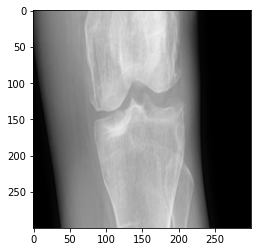

In [ ]:
plt.imshow(unseen_set[0][0].permute(1,2,0))
tran1 = transforms.ToPILImage()
# x = torch.randn(64, 3, 32, 32) # 64 images here
pil_image_single = tran1(unseen_set[0][0]) # this works fine
# pil_image_single.save("im3.jpg")
unseen_set[0][1]

In [ ]:
from tabulate import tabulate

print(tabulate([[len(train_aug_set), len(val_aug_set), len(unseen_set), len(train_aug_set)+len(val_aug_set)+len(unseen_set)]], 
               headers=['train', 'val', 'test', 'total']))

  train    val    test    total
-------  -----  ------  -------
   5641   1411    1764     8816


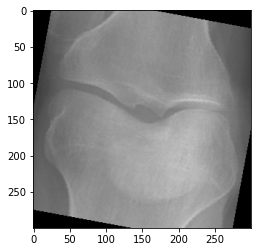

In [ ]:
plt.imshow(train_aug_set[0][0].permute(1,2,0))

Training Loop

In [ ]:
dataloaders = {"train":train_aug_dataloader,"val":val_aug_dataloader}
dataset_sizes = {"train":train_aug_size,"val":val_aug_size}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        count=0
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                if count%20==0:
                  print(count)
                # print(inputs,labels)
                count+=1
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "/content/drive/MyDrive/Knee_Osteo_Project/Saved_Models/inception_model_3way_ex1_aug_dict_30.7.pt")
    return model

In [ ]:
len(train_aug_set)

5641

Loading the Model

In [ ]:
import torchvision.models as models
# model_ft = models.resnet18(pretrained=True)

# model_ft=models.vgg16(pretrained=True)

# model_ft= RpsClassifier()
model_ft = models.inception_v3(pretrained=True)
model_ft.aux_logits=False
# model_ft.fc

in_feat = model_ft.fc.in_features

# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft.fc = nn.Linear(in_feat,3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

learning_rate= 1e-4 

optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft

In [ ]:
model_ft.fc

Run the Model

In [ ]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


20
40
60
80
100
120
140
160
train Loss: 0.6638 Acc: 0.6797
180
200
220
val Loss: 0.8792 Acc: 0.6662

Epoch 1/14
----------
0
20
40
60
80
100
120
140
160
train Loss: 0.4782 Acc: 0.7867
180
200
220
val Loss: 0.4242 Acc: 0.8072

Epoch 2/14
----------
0
20
40
60
80
100
120
140
160
train Loss: 0.4138 Acc: 0.8183
180
200
220
val Loss: 0.5422 Acc: 0.7633

Epoch 3/14
----------
0
20
40
60
80
100
120
140
160
train Loss: 0.3710 Acc: 0.8383
180
200
220
val Loss: 0.5726 Acc: 0.7356

Epoch 4/14
----------
0
20
40
60
80
100
120
140
160
train Loss: 0.3489 Acc: 0.8541
180
200
220
val Loss: 0.3234 Acc: 0.8696

Epoch 5/14
----------
0
20
40
60
80
100
120
140
160
train Loss: 0.3231 Acc: 0.8637
180
200
220
val Loss: 0.3744 Acc: 0.8370

Epoch 6/14
----------
0
20
40
60
80
100
120
140
160
train Loss: 0.3080 Acc: 0.8734
180
200
220
val Loss: 0.3974 Acc: 0.8519

Epoch 7/14
----------
0
20
40
60
80
100
120
140
160
train Loss: 0.2792 Acc: 0.8860
180
200
220
val Loss: 0.3430 Acc: 0.8646

Epoch 8/14
----------
0


In [ ]:
# os.chdir("/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/BaseLine Model")
# torch.save(model_ft, "inception_pretrained_3way_aug_30jul.pt")
# torch.save(model_ft.state_dict(), "inception_pretrained_3way_aug_30jul_dict.pt")

### Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,cohen_kappa_score,confusion_matrix,roc_curve,balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold
from tabulate import tabulate

def check_accuracy(model,loader):
  model.eval()
  num_pred=[]
  y_model=[]
  num_samples=0
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    scores =  model(inputs)
    _, predictions = scores.max(1)
    num_pred.extend(predictions.tolist())
    y_model.extend(labels.tolist())
    
  accuracy = accuracy_score(np.array(y_model), np.array(num_pred))
  conf_matrix = confusion_matrix(np.array(y_model), np.array(num_pred))
  bal_acc = balanced_accuracy_score(np.array(y_model), np.array(num_pred))
  print("Accuracy: {}\nConfusion Matrix:\n{}\nBalanced Accuracy: {}".format(accuracy,conf_matrix,bal_acc))
  return accuracy, conf_matrix, bal_acc


In [ ]:
print('After Removing Grade 1: Inception v3 (With augmentation)\n')

print("Training:\n------")
train_accuracy, train_conf_matrix, train_bal_acc = check_accuracy(model_ft, train_aug_dataloader)
print()
print("Validation:\n------")
val_accuracy, val_conf_matrix, val_bal_acc = check_accuracy(model_ft, val_aug_dataloader)
print()
print("Testing:\n------")
test_accuracy, test_conf_matrix, test_bal_acc = check_accuracy(model_ft, unseen_dataloader)

After Removing Grade 1: Inception v3 (With augmentation)

Training:
------
Accuracy: 0.923063286651303
Confusion Matrix:
[[2452   11  209]
 [  19  280    0]
 [ 195    0 2475]]
Balanced Accuracy: 0.9270286040972806

Validation:
------
Accuracy: 0.888731396172927
Confusion Matrix:
[[583   8  66]
 [ 11  62   0]
 [ 72   0 609]]
Balanced Accuracy: 0.8769850050400408

Testing:
------
Accuracy: 0.8792517006802721
Confusion Matrix:
[[716  12  85]
 [ 22  79   0]
 [ 94   0 756]]
Balanced Accuracy: 0.850759596471911


In [ ]:
precisions = []
recalls = []

for i in range(len(test_conf_matrix)):
  sum_p = 0
  sum_r = 0
  for j in range(len(test_conf_matrix)):
    sum_p += test_conf_matrix[j][i]
    sum_r += test_conf_matrix[i][j]
  precisions.append(round(test_conf_matrix[i][i]/sum_p, 4))
  recalls.append(round(test_conf_matrix[i][i]/sum_r, 4))

print('Precision:', precisions)
print('Recall:', recalls)

Precision: [0.8606, 0.8681, 0.8989]
Recall: [0.8807, 0.7822, 0.8894]


Pipeline

In [ ]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

map_dic = {0:"Early",1:"Late",2:"Normal"}

model = models.inception_v3(pretrained=True) # we do not specify pretrained=True, i.e. do not load default weights
model.aux_logits=False
in_feat = model.fc.in_features
model.fc = nn.Linear(in_feat,3)

model.load_state_dict(torch.load("/content/drive/MyDrive/Knee_Osteo_Project/Saved_Models/inception_model_3way_ex1_aug_dict_30.7.pt"))
model.eval()

def predict_output(model,path):
  model.eval()
  im = Image.open(path)
  transform = transforms.Compose([transforms.Resize((300,300)),transforms.ToTensor()])
  img = transform(im)
  print(img.shape)
  output=model(img.view(1,3,300,300)).to(device)
  return output.softmax(dim=1).argmax(dim=1).item()

output=predict_output(model,"/content/drive/MyDrive/Osteoarthritis Project/Data Received (Knee X-ray)/X-Ray Images/17-7-21/Grade 4 Knee X-Ray/Pictures from phone/WhatsApp Image 2021-07-17 at 1.01.32 PM (10).jpeg")
map_dic[output]


# Explainability
---

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision.models as models

plt.ion()   # interactive mode

In [ ]:
transform = transforms.Compose([transforms.Resize((300,300)),
                                transforms.ToTensor() ])

augmentation_transform = transforms.Compose([transforms.Resize((300,300)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.RandomRotation(degrees=(-90, 90)),
                                            transforms.RandomAutocontrast(),
                                            transforms.ColorJitter(hue=.05, saturation=.05),
                                            transforms.ToTensor()])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model_ft = models.inception_v3(pretrained=True)
model_ft.aux_logits=False
in_feat = model_ft.fc.in_features
model_ft.fc = nn.Linear(in_feat,3)

model_ft = model_ft.to(device)

In [ ]:
model_ft.load_state_dict(torch.load("/content/drive/MyDrive/Knee_Osteo_Project/Saved_Models/inception_model_3way_ex1_aug_dict_30.7.pt"))

In [ ]:
!pip install captum

In [ ]:
# model_ft

In [ ]:
saved_datasets ="/content/drive/MyDrive/Knee_Osteo_Project/Saved_Datasets/"
load_train = torch.load(saved_datasets+"train_inception_exc1.pt")
load_val = torch.load(saved_datasets+"val_inception_exc1.pt")
load_unseen = torch.load(saved_datasets+"unseen_inception_exc1.pt")

train_aug_set = load_train
val_aug_set = load_val
unseen_set = load_unseen

In [ ]:
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function to its items.

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        return self.map(self.dataset[index][0]), self.dataset[index][1]

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_aug_set = MapDataset(train_aug_set, augmentation_transform)
train_aug_dataloader = torch.utils.data.DataLoader(train_aug_set, batch_size=32, shuffle=True)

In [ ]:
val_aug_set = MapDataset(val_aug_set, transform)
val_aug_dataloader = torch.utils.data.DataLoader(val_aug_set, batch_size=32, shuffle=True)

In [ ]:
unseen_set = MapDataset(unseen_set, transform)
unseen_dataloader = torch.utils.data.DataLoader(unseen_set, batch_size=32, shuffle=True)

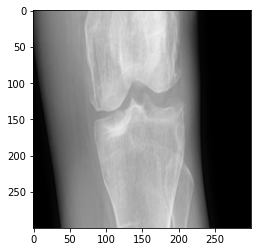

In [ ]:
plt.imshow(unseen_set[0][0].permute(1,2,0))

### Function Defintions

#### 1 Captum
---

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

def xai_captum(item_name, filename):
  integrated_gradients = IntegratedGradients(model_ft)
  model_ft.to(device)
  model_ft.eval()
  input = item_name.view(1,3,300,300).to(device)
  
  output = model_ft(input).to(device).softmax(dim=1).argmax(dim=1).item()
  attributions_ig = integrated_gradients.attribute(input, target=output, n_steps=50)

  default_cmap = LinearSegmentedColormap.from_list('custom red', 
                                                 [(0, '#000000'),
                                                  (0.5, '#ff3f2e'),
                                                  (1, '#b81f1f')], N=256)

  captum_img = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                              np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                              sign="positive",
                              method="blended_heat_map",
                              cmap=default_cmap,
                              # show_colorbar=True,
                              outlier_perc=5)
  
  # captum_img[0].suptitle(title)
  captum_img[0].savefig(filename, bbox_inches='tight',pad_inches = 0.1)

  return captum_img[0]

#### 2 Occlusion
---

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

def xai_occlusion(item_name, filename):
  occlusion = Occlusion(model_ft)

  input = item_name.view(1,3,300,300).to(device)
  output = model_ft(input).to(device).softmax(dim=1).argmax(dim=1).item()

  attributions_occ = occlusion.attribute(input,
                                        strides = (3, 8, 8),
                                        target=output,
                                        sliding_window_shapes=(3,15, 15),
                                        baselines=0)

  occlusion_img = viz.visualize_image_attr(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        sign="positive",
                                        method="blended_heat_map",
                                        # show_colorbar=True,
                                        outlier_perc=6)

  occlusion_img[0].savefig(filename, bbox_inches='tight', pad_inches = 0.1)

  return occlusion_img[0]

#### Scan 1
---

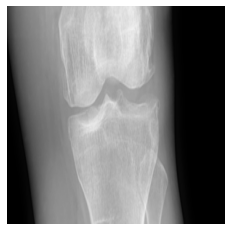

In [ ]:
plt.imshow(unseen_set[0][0].permute(1,2,0))
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/original_img1.png', bbox_inches='tight', pad_inches = 0.1)

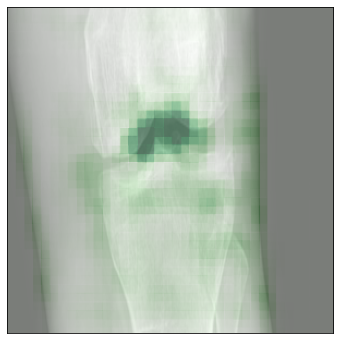

In [ ]:
occlusion_img = xai_occlusion(unseen_set[0][0], '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Occlusion/occ_img1.png')

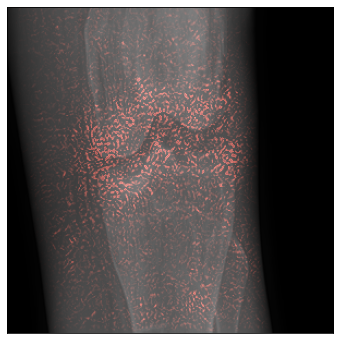

In [ ]:
captum_img = xai_captum(unseen_set[0][0], '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Captum/captum_img1.png')

#### Scan 2
---

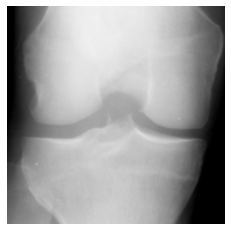

In [ ]:
plt.imshow(unseen_set[1001][0].permute(1,2,0))
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/original_img2.png', bbox_inches='tight', pad_inches = 0.1)

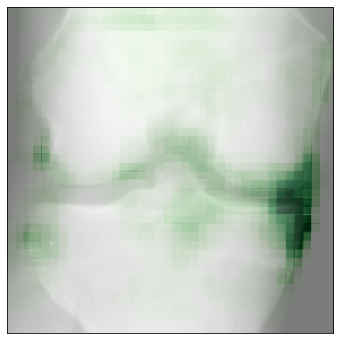

In [ ]:
occlusion_img = xai_occlusion(unseen_set[1001][0], '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Occlusion/occ_img2.png')

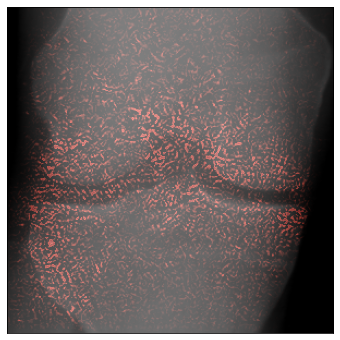

In [ ]:
captum_img = xai_captum(unseen_set[1001][0], '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Captum/captum_img2.png')

#### Scan 3
---

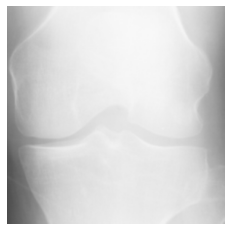

In [ ]:
plt.imshow(unseen_set[70][0].permute(1,2,0))
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/original_img3.png', bbox_inches='tight', pad_inches = 0.1)

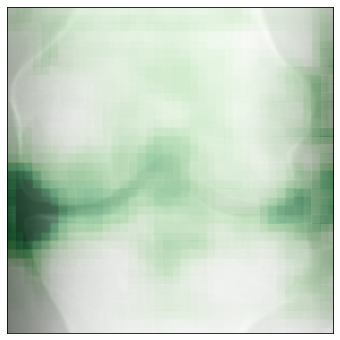

In [ ]:
occlusion_img = xai_occlusion(unseen_set[70][0], '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Occlusion/occ_img3.png')

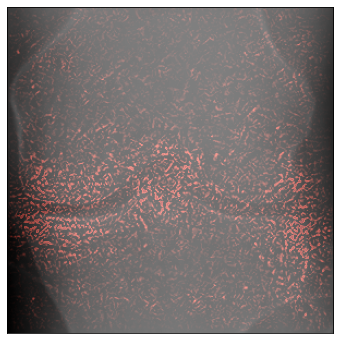

In [ ]:
captum_img = xai_captum(unseen_set[70][0], '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Captum/captum_img3.png')

#### Show All Plots
---

In [ ]:
def show_xai_plots(original, int_gradients, occlusion):
  f, axarr = plt.subplots(1,3,figsize=(14,14))
  
  axarr[0].imshow(cv2.imread(original))
  axarr[1].imshow(cv2.imread(int_gradients))
  axarr[2].imshow(cv2.imread(occlusion))

  axarr[0].title.set_text("Original")
  axarr[0].title.set_size(16)
  axarr[1].title.set_text("Integrated Gradeints")
  axarr[1].title.set_size(16)
  axarr[2].title.set_text("Occlusion")
  axarr[2].title.set_size(16)

  plt.subplots_adjust(wspace=0, hspace=0)

  axarr[0].axis('off')
  axarr[1].axis('off')
  axarr[2].axis('off')

  plt.show()

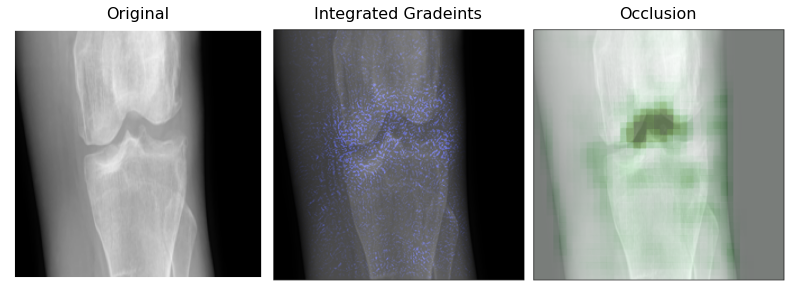

In [ ]:
show_xai_plots('/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/original_img1.png',
               '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Captum/captum_img1.png',
               '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Occlusion/occ_img1.png')

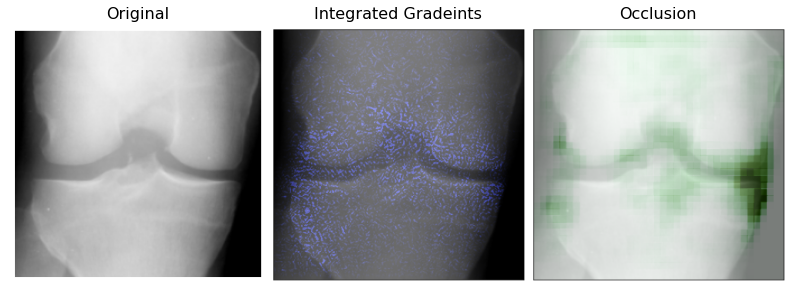

In [ ]:
show_xai_plots('/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/original_img2.png',
               '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Captum/captum_img2.png',
               '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Occlusion/occ_img2.png')

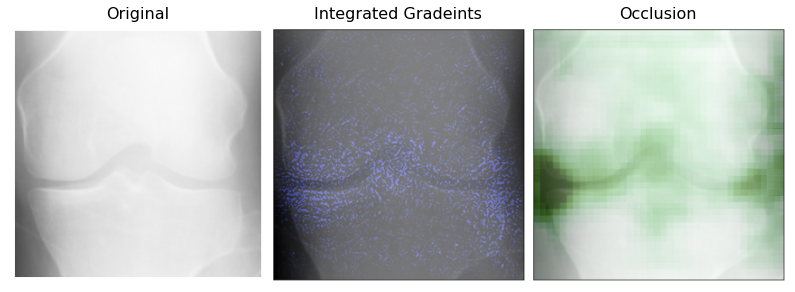

In [ ]:
show_xai_plots('/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/original_img3.png',
               '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Captum/captum_img3.png',
               '/content/drive/MyDrive/Osteoarthritis Project (Sayon Sir)/Explainable_AI_images/Occlusion/occ_img3.png')